In [2]:
import sys, os
print('Python:  ', sys.version)
print('Active Conda Environment: ', os.getenv('CONDA_DEFAULT_ENV'))

Python:   3.12.12 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 20:05:38) [MSC v.1929 64 bit (AMD64)]
Active Conda Environment:  pyarima


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error

In [17]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Case-1:- ARIMA

In [18]:
df = pd.read_csv('ch5_arma.csv')
df['dates'] = pd.to_datetime(df['dates'])
df = df.set_index('dates')
df = df.sort_index()
df = df.asfreq('W-FRI')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2010-01-01 to 2012-11-09
Freq: W-FRI
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   150 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


In [19]:
df

,sales
dates,
2010-01-01,10.496714
2010-01-08,10.441678
2010-01-15,10.940215
2010-01-22,12.348302
2010-01-29,12.029855
...,...
2012-10-12,15.698852
2012-10-19,14.712528
2012-10-26,12.949804


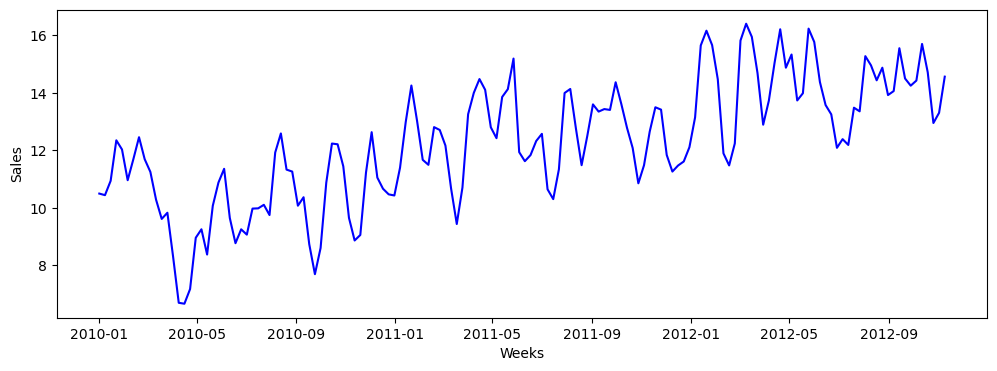

In [20]:
plt.figure(figsize=(12, 4))
#plt.title('Time Series Data with Train/Test Split')
plt.plot(df.index, df, label='Train Data', color='blue')
plt.ylabel('Sales')
plt.xlabel('Weeks')
plt.show()

In [21]:
adf_result = adfuller(df, regression='c')
print(f"Initial ADF Test P-value: {adf_result[1]:.4f} (Expected <= 0.05 for Stationarity")

df_diff = df.diff(periods=1)
df_diff = df_diff.dropna()

adf_result = adfuller(df_diff, regression='c')
print(f"ADF Test P-value: {adf_result[1]:.4f} (Expected <= 0.05 for Stationarity)")

Initial ADF Test P-value: 0.3508 (Expected <= 0.05 for Stationarity
ADF Test P-value: 0.0000 (Expected <= 0.05 for Stationarity)


Total Observations: 150
Training Set Size: 125
Test Set Size: 25
--------------------------------------------------
Initial ADF Test P-value: 0.3508 (Expected > 0.05)


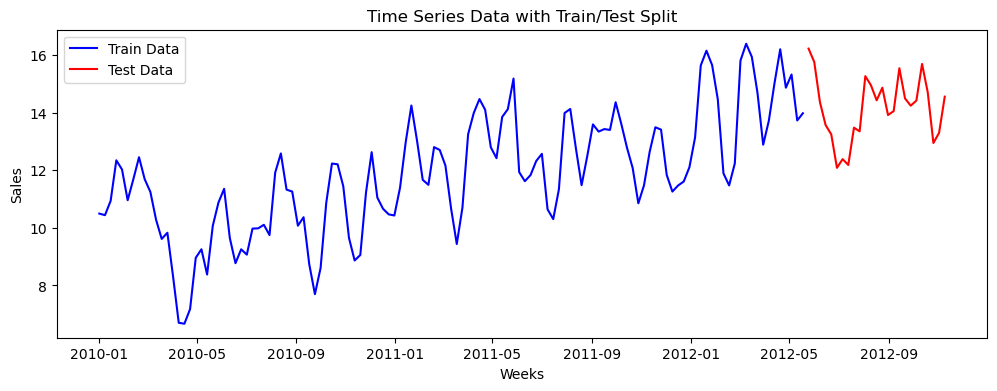

In [22]:
# 2. Initial Examination and Train-Test Split
N=150
train = df[:-25]
test = df[-25:]

print(f"Total Observations: {N}")
print(f"Training Set Size: {len(train)}")
print(f"Test Set Size: {len(test)}")
print("-" * 50)

# Optional: Initial ADF Test on Raw Data (Should fail, indicating non-stationarity)
adf_result = adfuller(df, regression='c')
print(f"Initial ADF Test P-value: {adf_result[1]:.4f} (Expected > 0.05)")

plt.figure(figsize=(12, 4))
plt.title('Time Series Data with Train/Test Split')
#df.plot(label='Full Data')
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='red')
plt.legend()
plt.ylabel('Sales')
plt.xlabel('Weeks')
plt.show()

In [23]:
# ====================================================================
# PHASE 2: Automated ARIMA Tuning (pmdarima)
# ====================================================================
print("\nPHASE 2: Running Automated ARIMA Tuning...")
# Use auto_arima to automatically select the best p, d, q orders
# Information Criterion (ic) set to 'bic' for a more parsimonious model
# Stepwise=True for faster execution
# D=0 and m=1 to explicitly disable seasonal search (non-seasonal model)

import pmdarima as pm
model_auto = pm.auto_arima(
    train,
    start_p=1, max_p=3,
    start_q=1, max_q=3,
    d=None, max_d=2, # Let auto_arima estimate the differencing order 'd'
    seasonal=False,
    stepwise=True, trace=True,
    suppress_warnings=True,
    error_action='ignore',
    information_criterion='bic')


PHASE 2: Running Automated ARIMA Tuning...
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=396.250, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=399.433, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=395.587, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=391.451, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=394.685, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=389.739, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : BIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=385.951, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=386.682, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=375.281, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=391.484, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=367.929, Time=0.08 sec
 ARIMA(2,1,1)(0

In [24]:
best_order = model_auto.order
print(f"Best ARIMA Order (p, d, q): {best_order}")

Best ARIMA Order (p, d, q): (2, 1, 1)


In [25]:
# Print the best model summary
print("\n--- Optimized Model Summary ---")
print(model_auto.summary())


--- Optimized Model Summary ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -172.029
Date:                Tue, 25 Nov 2025   AIC                            352.058
Time:                        21:23:45   BIC                            363.340
Sample:                    01-01-2010   HQIC                           356.641
                         - 05-18-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9556      0.107      8.943      0.000       0.746       1.165
ar.L2         -0.5164      0.087     -5.954      0.000      -0.686      -0.346
ma.L1         -0.81

In [26]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [27]:
import warnings
warnings.filterwarnings("ignore") 

In [28]:
model = ARIMA(train, order=(2,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                  125
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -172.029
Date:                Tue, 25 Nov 2025   AIC                            352.058
Time:                        21:23:45   BIC                            363.340
Sample:                    01-01-2010   HQIC                           356.641
                         - 05-18-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9556      0.107      8.943      0.000       0.746       1.165
ar.L2         -0.5164      0.087     -5.954      0.000      -0.686      -0.346
ma.L1         -0.8169      0.068    -11.978      0.000      -0.951      -0.683
sigma2         0.9306      0.111      8.348      0.000       0.712       1.149
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.74   Prob(JB):                         0.46
Heteroskedasticity (H):               0.88   Skew:                            -0.14
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

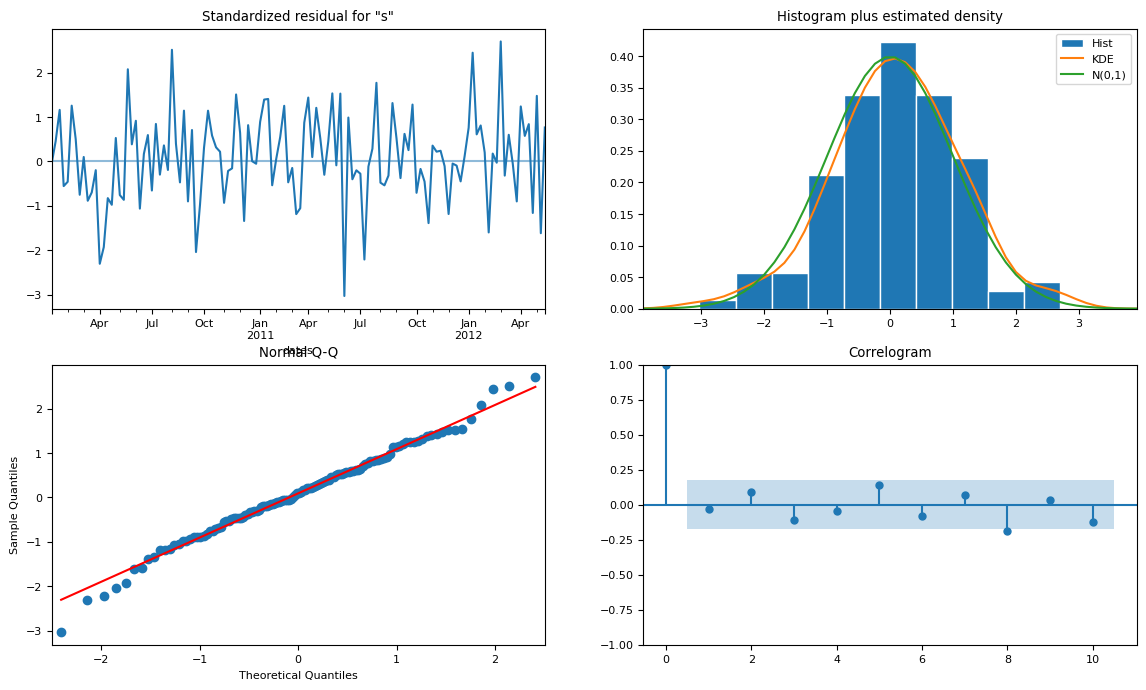

In [37]:
plt.rcParams.update({'font.size': 8})
results.plot_diagnostics(figsize=(14,8))
plt.show()
plt.rcParams.update({'font.size': 10})

### Forecast performance

In [38]:
train_pred = results.predict(start=train.index[2], end=train.index[-1])
test_pred = results.forecast(25)

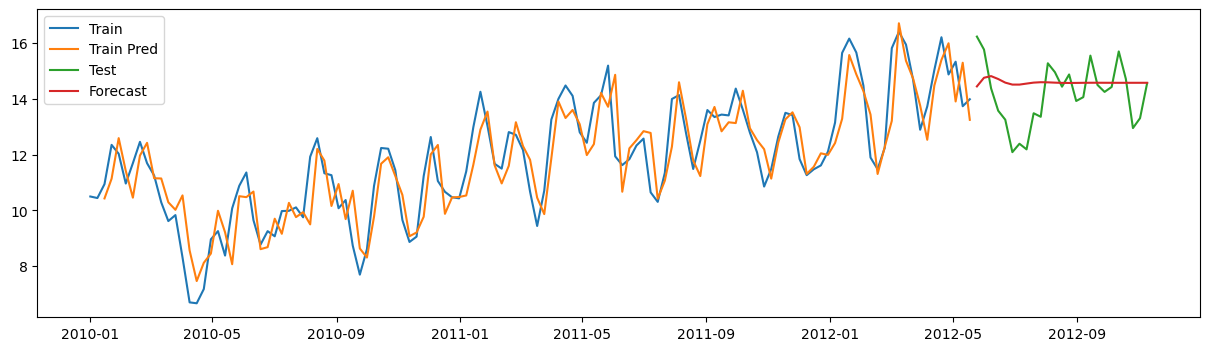

In [39]:
plt.figure(figsize=(15, 4))
plt.plot(train, label='Train')
plt.plot(train_pred, label='Train Pred')
plt.plot(test, label='Test')
plt.plot(test_pred, label='Forecast')
plt.legend()
plt.show()

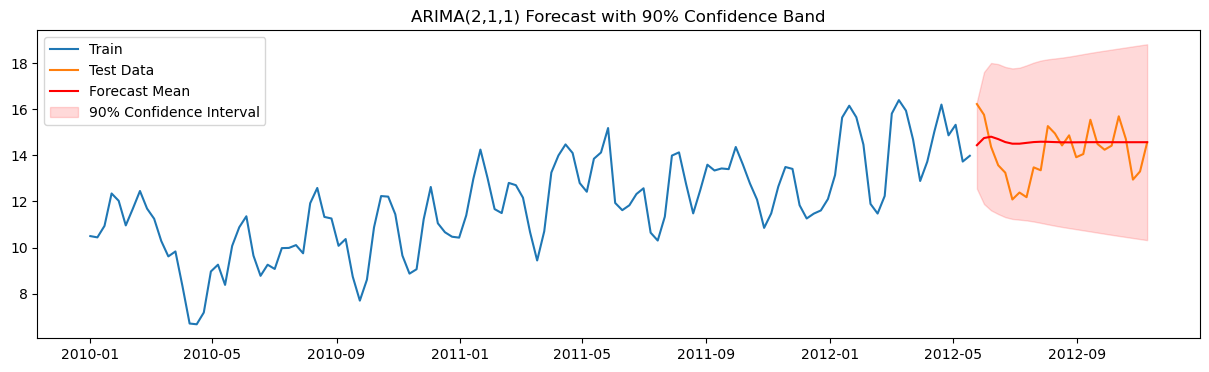

In [40]:
model = ARIMA(train, order=(2,1,1))
results = model.fit()

forecast_result = results.get_forecast(steps=len(test), alpha=0.1)
test_pred = forecast_result.predicted_mean
conf_int = forecast_result.conf_int() # This returns a DataFrame/array with lower and upper bounds
lower_ci = conf_int.iloc[:, 0]
upper_ci = conf_int.iloc[:, 1]

plt.figure(figsize=(15, 4))
plt.plot(train, label='Train')
plt.plot(test, label='Test Data')
plt.plot(test_pred, label='Forecast Mean', color='red')

plt.fill_between(test.index, lower_ci, upper_ci, 
    color='r', alpha=0.15, label='90% Confidence Interval')

plt.legend()
plt.title('ARIMA(2,1,1) Forecast with 90% Confidence Band')
plt.show()

In [41]:
train_pred = results.predict()
test_pred = results.forecast(25)

In [42]:
from sklearn.metrics import root_mean_squared_error
mse_train = root_mean_squared_error(train, train_pred)
mse_test = root_mean_squared_error(test, test_pred)
print('Train RMSE:  ', mse_train)
print('Test RMSE:  ', mse_test)

Train RMSE:   1.3445947148888289
Test RMSE:   1.1688858516297422


In [43]:
np.mean(test)

np.float64(14.166192797381202)

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 3. Calculate Metrics for Train and Test Sets ---
def calculate_metrics(y_actual, y_pred, set_name):
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    return {'Set': set_name, 'MAE': mae,'MAPE(%)': mape, 'RMSE': rmse}

# Calculate metrics for both sets
train_metrics = calculate_metrics(train, train_pred, 'Train')
test_metrics = calculate_metrics(test, test_pred, 'Test')

# --- 4. Create and Present the Results Table ---
results_df = pd.DataFrame([train_metrics, test_metrics])

# Format the numerical columns for better readability
results_df['MAE'] = results_df['MAE'].map('{:.2f}'.format)
results_df['RMSE'] = results_df['RMSE'].map('{:.2f}'.format)
results_df['MAPE(%)'] = results_df['MAPE(%)'].map('{:.2f}'.format)


print(results_df.set_index('Set'))

        MAE MAPE(%)  RMSE
Set                      
Train  0.83    0.07  1.34
Test   0.93    0.07  1.17


#### Case-2:- SARIMA

In [60]:
df2 = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
df2.index.freq='MS'
df = df2.copy()
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [61]:
df.shape

(144, 1)

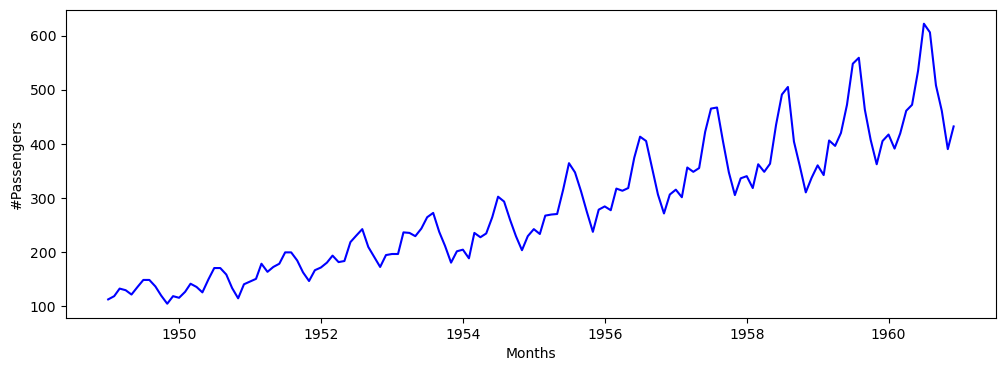

In [57]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df, label='Train Data', color='blue')
plt.ylabel('#Passengers')
plt.xlabel('Months')
plt.show()

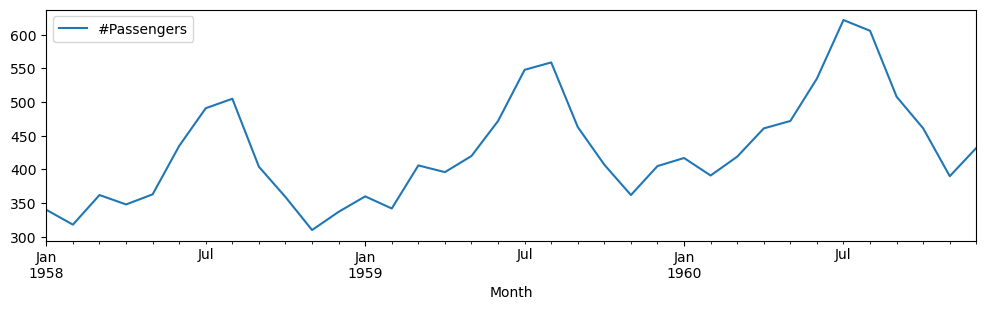

In [58]:
dfs = df[df.index.year>=1958]
dfs.plot(figsize=(12, 3))
plt.show()

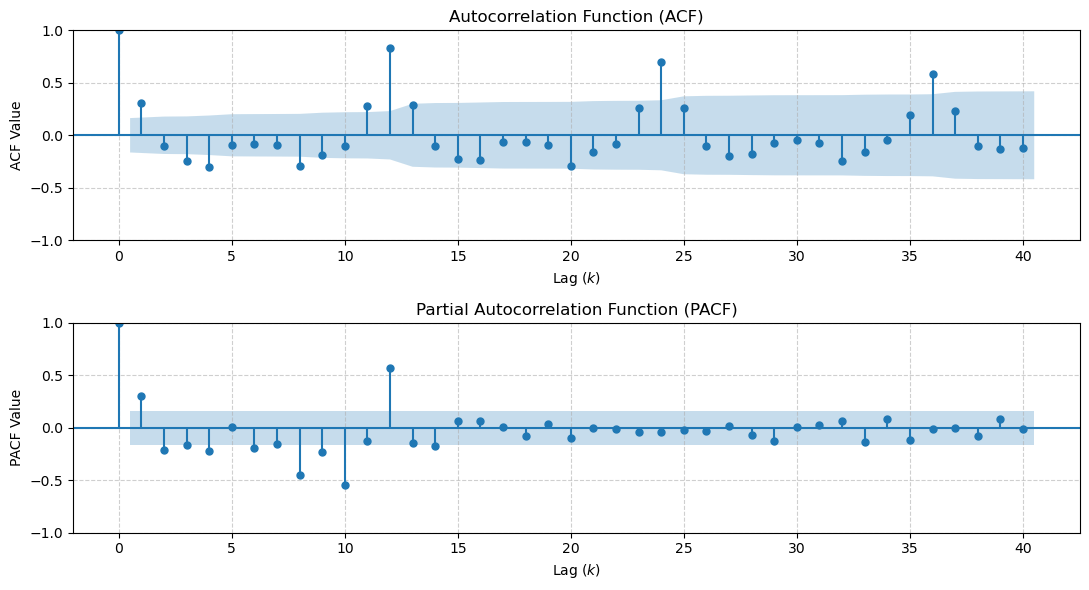

In [59]:
df1d = df['#Passengers'].diff()
df1d = df1d.dropna()

fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharex=False)
plot_acf(df1d, ax=axes[0], lags=40, alpha=0.05, title='Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag ($k$)')
axes[0].set_ylabel('ACF Value')
axes[0].grid(True, linestyle='--', alpha=0.6)

plot_pacf(df1d, ax=axes[1], lags=40, alpha=0.05, method='ywmle', title='Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag ($k$)')
axes[1].set_ylabel('PACF Value')
axes[1].grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

### ARIMA Mdeling Process

In [92]:
df = df2.copy()
train = df[:120]
test = df[120:]

In [93]:
from pmdarima import auto_arima
auto_model = auto_arima(train, 
    start_p=0, d=None, start_q=0, 
    max_p=2, max_d=2, max_q=2,
    start_P=0, D=None, start_Q=0, 
    max_P=2, max_D=2, max_Q=2,
    max_order=6, m=12, stepwise=True, trace=True)

#auto_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=910.236, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=810.646, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=860.575, Time=0.20 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1060.479, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=809.411, Time=0.08 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=810.721, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=812.509, Time=0.49 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=808.863, Time=0.09 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=810.482, Time=0.27 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=810.553, Time=0.21 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=809.672, Time=0.15 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=809.448, Time=0.09 sec
 ARIMA(2,0,0)(0,1,0)[12]             : AIC=812.240, Time=0.04 sec

Best model:  ARIMA(2,0,0)(0,1,0)[12

In [94]:
model = SARIMAX(train, order=(2, 0, 0), seasonal_order=(0,1,0,12), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Thu, 30 Oct 2025   AIC                            808.863
Time:                                    13:10:22   BIC                            819.592
Sample:                                01-01-1949   HQIC                           813.213
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0,1,0,12), trend='c')
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -401.706
Date:                            Thu, 30 Oct 2025   AIC                            809.411
Time:                                    14:17:19   BIC                            817.458
Sample:                                01-01-1949   HQIC                           812.674
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.3420      2.055      2.600      0.009       1.315       9.369
ar.L1          0.7981      0.066     12.088      0.000       0.669       0.928
sigma2        98.6491     11.688      8.440      0.000      75.741     121.557
===================================================================================
Ljung-Box (L1) (Q):                   1.85   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.17   Prob(JB):                         0.28
Heteroskedasticity (H):               1.29   Skew:                            -0.06
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

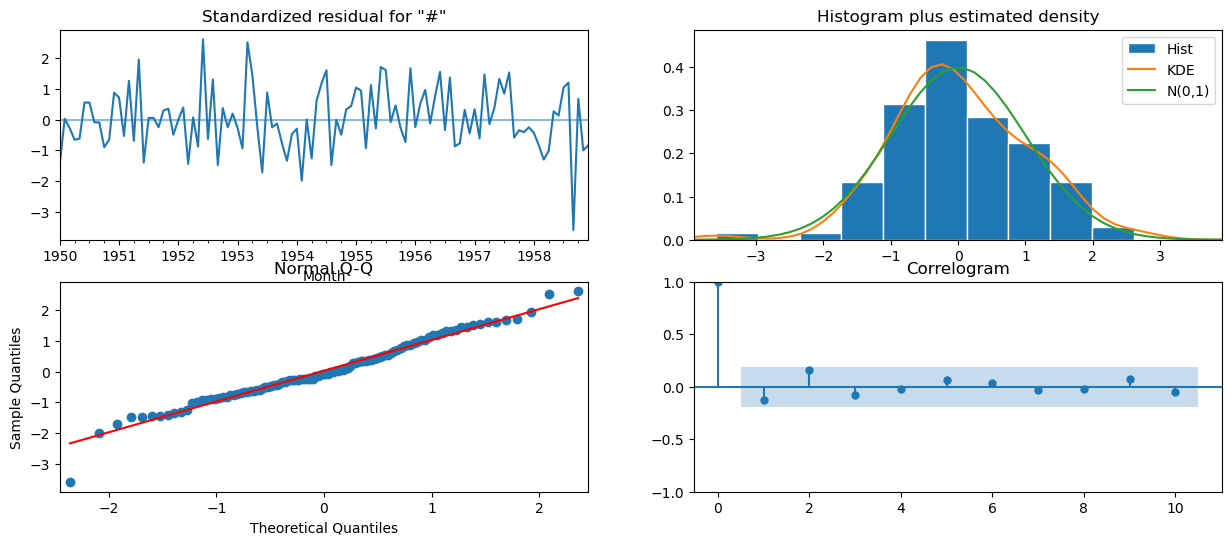

In [96]:
results.plot_diagnostics(figsize=(15,6))
plt.show()

In [97]:
train_pred = results.predict(start=train.index[0], end=train.index[-1])
test_pred = results.forecast(24)

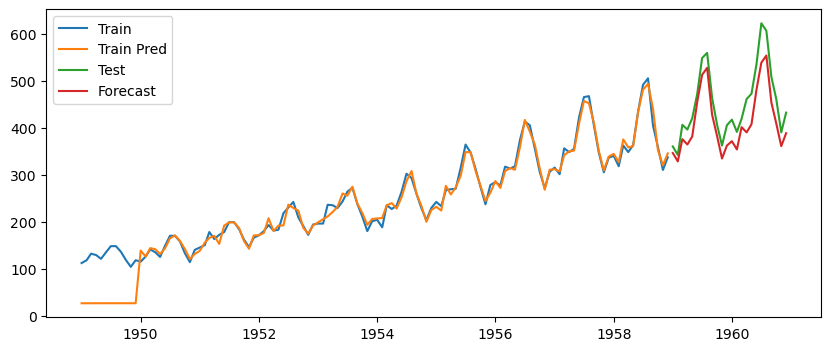

In [98]:
plt.figure(figsize=(10, 4))
plt.plot(train, label='Train')
plt.plot(train_pred, label='Train Pred')
plt.plot(test, label='Test')
plt.plot(test_pred, label='Forecast')
plt.legend()
plt.show()

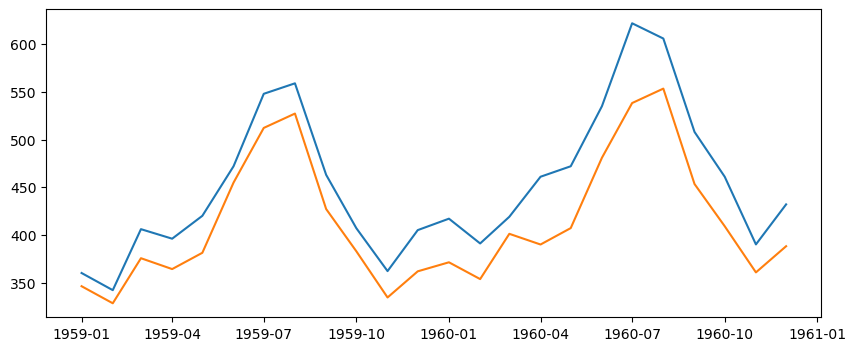

In [99]:
plt.figure(figsize=(10, 4))
plt.plot(test)
plt.plot(test_pred)
plt.show()

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 3. Calculate Metrics for Train and Test Sets ---
def calculate_metrics(y_actual, y_pred, set_name):
    mae = mean_absolute_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    return {'Set': set_name, 'MAE': mae,'MAPE(%)': mape, 'RMSE': rmse}

# Calculate metrics for both sets
train_metrics = calculate_metrics(train, train_pred, 'Train')
test_metrics = calculate_metrics(test, test_pred, 'Test')

# --- 4. Create and Present the Results Table ---
results_df = pd.DataFrame([train_metrics, test_metrics])

# Format the numerical columns for better readability
results_df['MAE'] = results_df['MAE'].map('{:.2f}'.format)
results_df['RMSE'] = results_df['RMSE'].map('{:.2f}'.format)
results_df['MAPE(%)'] = results_df['MAPE(%)'].map('{:.2f}'.format)


print(results_df.set_index('Set'))

         MAE MAPE(%)   RMSE
Set                        
Train  17.10    0.11  33.34
Test   39.65    0.09  43.38


In [100]:
train_mse =  mean_squared_error(train, train_pred)
print('train_mse', train_mse)
test_mse = mean_squared_error(test, test_pred)
print('test_mse', test_mse)

train_mse 1111.7464934132029
test_mse 1881.4907268213528
